In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pygmt
from obspy.core import UTCDateTime

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import os
import json

In [2]:
# Read in features, look at names & datatypes
df_original = pd.read_csv('../s_features.csv', dtype={'location_code': str})
print(len(df_original))
print(df_original.dtypes)

14152
arrival_identifier                        int64
channel1                                 object
channel2                                 object
event_identifier                          int64
location_code                            object
                                         ...   
transverse_signal_dominant_amplitude    float64
transverse_signal_dominant_frequency    float64
transverse_signal_maximum_value         float64
transverse_signal_minimum_value         float64
transverse_signal_variance              float64
Length: 106, dtype: object


In [3]:
# Get metadata for 1 and 3c stations
eq_meta_onec = pd.read_csv("../currentEarthquakeArrivalInformation1CWithGains.csv")
eq_meta_threec = pd.read_csv("../currentEarthquakeArrivalInformation3CWithGains.csv")
eq_meta_all = pd.concat([eq_meta_onec, eq_meta_threec])

# Reduce to just location information
all_eq_locs = eq_meta_all.drop_duplicates("evid")[["evid", "event_lat", "event_lon", "origin_time"]]
all_eq_locs.columns = ["event_identifier", "event_lat", "event_lon", "origin_time"]

# Reduce to events in the dataset 
eq_locs_df = all_eq_locs[np.isin(all_eq_locs.event_identifier, df_original.event_identifier.unique())]
# Make date column for filtering
eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))

/tmp/ipykernel_127772/187499698.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  eq_meta_threec = pd.read_csv("../currentEarthquakeArrivalInformation3CWithGains.csv")
/tmp/ipykernel_127772/187499698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))


In [4]:
# Set filter bounds
lat_min = 44.680
lat_max = 44.870
lon_max = 110.850
lon_min = 110.640
date_min = 130901  # YYMMDD
date_max = 140630  # YYMMDD
bounds = {"lat_min": lat_min,
          "lat_max": lat_max,
          "lon_max": lon_max,
          "lon_min": lon_min,
          "date_min": date_min,
          "date_max": date_max}

# Get ngb event ids
ngb_event_locs = eq_locs_df.loc[
        (eq_locs_df["date"] >= bounds["date_min"]) & (eq_locs_df["date"] <= bounds["date_max"]) & (eq_locs_df["event_lat"] >= bounds["lat_min"])
        & (eq_locs_df["event_lat"] <= bounds["lat_max"]) & (-1 * eq_locs_df["event_lon"] >= bounds["lon_min"]) & (
                    -1 * eq_locs_df["event_lon"] <= bounds["lon_max"])]

In [5]:
df_ngb_removed = df_original[~np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
df_ngb = df_original[np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
np.where(np.isin(df_ngb_removed.event_identifier, df_ngb.event_identifier))

(array([], dtype=int64),)

In [6]:
# Keep stations with more than 200 observations (all together, including NGB)
stat_counts = df_original.value_counts("station").to_frame().reset_index()
stat_counts.columns = ["Station", "Count"]
stat_counts.to_csv("feature_station_counts.csv", index=False)
df_org_filtcounts = df_ngb_removed[np.isin(df_ngb_removed.station, stat_counts[stat_counts.Count >= 200])]
df_ngb_filtcounts = df_ngb[np.isin(df_ngb.station, stat_counts[stat_counts.Count >= 200])]

In [7]:
# Computes the feature matrix from a dataframe
def compute_feature_df(df, scaler=None, include_noise_var=False):
    # Loosely speaking empirical magnitudes look like:
    # M = log10(A) + Q(Delta) 
    # where A is the amplitude and Q a distance dependent correction term.
    # Additionally, the difference between log10 and log amounts to a scalar
    # that a machine can learn.
    # Basically, I'm interested in features that:
    #   (1) Measure size in, potentially, different amplitudes.
    # different `passbands' deviates from the noise, 
    n_rows = len(df)
    n_columns = 9
        
    X = np.zeros([n_rows, n_columns])
    
    w1 = 0.5
    w2 = 1 - w1
    
    # Get a proxy on size
    

#      ['amp_ratio_01.0', 'amp_02.0', 'signal_variance', 'noise_variance', 'noise_max_amplitude', 
#          'signal_max_amplitude', 'source_receiver_distance_logkm', 'source_depth_km','receiver_back_azimuth'] 
        
    # These are effectively amplitude ratios.  Note,
    # log(a/b) = log(a) - log(b)
    X[:,0]  = w1*(np.log(df['radial_avg_signal_1.00']) - np.log(df['radial_avg_noise_1.00'])) \
            + w2*(np.log(df['transverse_avg_signal_1.00']) - np.log(df['transverse_avg_noise_1.00']))
    # Look at amplitudes
    X[:,1] = w1*np.log(df['radial_avg_signal_2.00']) + w2*np.log(df['transverse_avg_signal_2.00']) 
    # Time-based featuers: Look at max amplitudes of noise/signal
    X[:,2] = w1*np.log(df['radial_signal_variance']) + w2*np.log(df['transverse_signal_variance'])
    X[:,3] = w1*np.log(df['radial_noise_variance']) + w2*np.log(df['transverse_noise_variance']) 
    X[:,4] = w1*(np.log(df['radial_noise_maximum_value'] - df['radial_noise_minimum_value'])) \
            + w2*(np.log(df['transverse_noise_maximum_value'] - df['transverse_noise_minimum_value']))
    X[:,5] = w1*(np.log(df['radial_signal_maximum_value'] - df['radial_signal_minimum_value'])) \
            + w2*(np.log(df['transverse_signal_maximum_value'] - df['transverse_signal_minimum_value']))
    # Source/recv distance (take log to flatten this)
    X[:,6] = np.log(df['source_receiver_distance_km'])
    X[:,7] = df['source_depth_km']
    # Single stations can learn location
    X[:,8] = df['source_receiver_back_azimuth']
    

    # Standardize features
    if (scaler is None):
        scaler = StandardScaler()
        scaler = scaler.fit(X)
    
    X = scaler.transform(X)
    return X, scaler

Working on station: YNR
1695 training examples - 79.80225988700565%
429 testing examples - 20.19774011299435%
SVR with all features:
Test MSE 0.028910843703185286
Test R2: 0.9051564186667437
Train MSE 0.01831077475609351
Train R2: 0.9363181978462807
114 NGB examples
NGB MSE 0.09450113278305443
NGB R2: 0.7291015885323346
Working on station: YMR


/tmp/ipykernel_127772/3959157276.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_127772/3959157276.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
/tmp/ipykernel_127772/3959157276.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

1145 training examples - 80.1259622113366%
284 testing examples - 19.8740377886634%
SVR with all features:
Test MSE 0.027957272668776772
Test R2: 0.8945161544582723
Train MSE 0.020993377567190618
Train R2: 0.9216602603835456
167 NGB examples
NGB MSE 0.05339273487272161
NGB R2: 0.8266717477511824
Working on station: YMC
1124 training examples - 79.21071176885131%
295 testing examples - 20.7892882311487%
SVR with all features:


/tmp/ipykernel_127772/3959157276.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_127772/3959157276.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
/tmp/ipykernel_127772/3959157276.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

Test MSE 0.03485393713810237
Test R2: 0.7875367661705304
Train MSE 0.029182461266169843
Train R2: 0.8030655509208263
44 NGB examples
NGB MSE 0.05928976216996217
NGB R2: 0.6291737000609722
Working on station: YHB
708 training examples - 79.90970654627539%
178 testing examples - 20.090293453724605%
SVR with all features:
Test MSE 0.028978986757336653
Test R2: 0.9095572318012866
Train MSE 0.015769939638860284
Train R2: 0.9542035651236441
283 NGB examples
NGB MSE 0.0405372681262245
NGB R2: 0.860290360032184
Working on station: YHH
715 training examples - 79.26829268292683%
187 testing examples - 20.73170731707317%
SVR with all features:
Test MSE 0.03451447275180471
Test R2: 0.8620957711134514
Train MSE 0.023232285293365417
Train R2: 0.8939826957574635
195 NGB examples
NGB MSE 0.08967667528642416
NGB R2: 0.6049632578877147
Working on station: YFT
713 training examples - 77.66884531590415%
205 testing examples - 22.33115468409586%
SVR with all features:


/tmp/ipykernel_127772/3959157276.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_127772/3959157276.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
/tmp/ipykernel_127772/3959157276.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

Test MSE 0.034308813818762225
Test R2: 0.8681199370136724
Train MSE 0.014234010598039906
Train R2: 0.94668640843012
11 NGB examples
NGB MSE 0.012096865125009652
NGB R2: 0.9419839918141323
Working on station: YUF
582 training examples - 78.64864864864865%
158 testing examples - 21.35135135135135%
SVR with all features:
Test MSE 0.05232987566115556
Test R2: 0.7558617606189896
Train MSE 0.038362586681565
Train R2: 0.8423476596069029
175 NGB examples
NGB MSE 0.055619600247420575
NGB R2: 0.7436804016324795
Working on station: YHL
459 training examples - 79.6875%
117 testing examples - 20.3125%
SVR with all features:
Test MSE 0.030883686963461016
Test R2: 0.9102038200267545
Train MSE 0.020858333366178244
Train R2: 0.9419075757096438
6 NGB examples
NGB MSE 0.17553576810172297
NGB R2: 0.7943214723405396
Working on station: YML
421 training examples - 83.53174603174604%
83 testing examples - 16.46825396825397%
SVR with all features:
Test MSE 0.053526601524883
Test R2: 0.8218501632504157
Train M

/tmp/ipykernel_127772/3959157276.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_127772/3959157276.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_127772/3959157276.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

Test MSE 0.021021672803048716
Test R2: 0.8797945519487778
Train MSE 0.01942301265440551
Train R2: 0.8915812845976552
Working on station: YNM
188 training examples - 80.68669527896995%
45 testing examples - 19.313304721030043%
SVR with all features:
Test MSE 0.031086577301330708
Test R2: 0.858538481753254
Train MSE 0.022886829064948395
Train R2: 0.9261171925599749
163 NGB examples
NGB MSE 0.06905777329176176
NGB R2: 0.7225292163721523
Working on station: B207
294 training examples - 80.54794520547945%
71 testing examples - 19.45205479452055%
SVR with all features:
Test MSE 0.051222518160719925
Test R2: 0.848042699165377
Train MSE 0.022968059980405055
Train R2: 0.9273822418684402
30 NGB examples
NGB MSE 0.18673103437589314
NGB R2: 0.5107768661553802
Working on station: FLWY
307 training examples - 79.12371134020619%
81 testing examples - 20.876288659793815%
SVR with all features:
Test MSE 0.04627913632573346
Test R2: 0.7343220188818669
Train MSE 0.028291822290219634
Train R2: 0.838303148

/tmp/ipykernel_127772/3959157276.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
/tmp/ipykernel_127772/3959157276.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est


(0.0, 1.0, 0.0, 1.0)

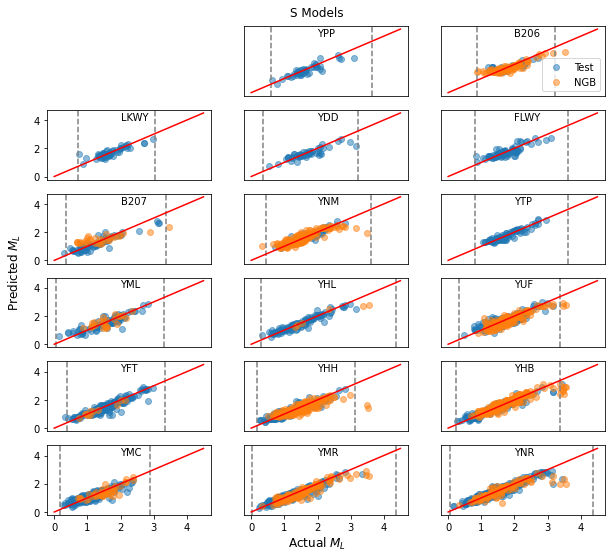

In [8]:
test_size = 0.2

C = 1.0
epsilon=0.1
model_out_path = f"S_magnitude_models_evid_C{C}_e{epsilon}_9features"

if not os.path.exists(model_out_path):
    os.makedirs(model_out_path)

n_stats = (stat_counts.Count > 200).sum()
first_stat = 0

# master evid seperation
evids = np.unique(df_org_filtcounts.event_identifier)
train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

n_cols = 3
n_rows = int(np.ceil((n_stats-first_stat)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 9))
cnt = 0

stat_results = {}
combined_test_summary = []
combined_ngb_summary = []

for station, ax in zip(stat_counts.iloc[first_stat:n_stats].Station.values, np.flip(axes.flatten())):
    print("Working on station:", station)
    
    station_df = df_org_filtcounts[df_org_filtcounts.station == station]
    if len(station_df) == 0:
        ax.axis('off')
        continue
#     evids = np.unique(station_df.event_identifier)
#     train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)
    
    train_inds = np.isin(station_df.event_identifier, train_evids)
    train_df = station_df[train_inds]
    test_df = station_df[~train_inds]

    train_count = len(train_df)
    test_count = len(test_df)
    
    print(f"{train_count} training examples - {(train_count/len(station_df))*100}%")
    print(f"{test_count} testing examples - {(test_count/len(station_df))*100}%")

#     assert len(train_df.event_identifier.unique()) == len(train_evids)
#     assert len(test_df.event_identifier.unique()) == len(test_evids)
    assert len(test_df) + len(train_df) == len(station_df)

    include_noise_var = False
#     if station == "YMC":
#         include_noise_var = True

    X_train, scaler = compute_feature_df(train_df, scaler=None, include_noise_var=include_noise_var)
    X_test, _ = compute_feature_df(test_df, scaler=scaler, include_noise_var=include_noise_var)
    
    y_train = train_df.magnitude.values
    y_test = test_df.magnitude.values
    
    print("SVR with all features:")
    svr = SVR(C=C, epsilon=epsilon, gamma="scale")
    svr.fit(X_train, y_train)
    
    y_est = svr.predict(X_test)
    train_est = svr.predict(X_train) 
    # Save train information
    train_results = np.concatenate([np.expand_dims(train_df.event_identifier.values, axis=1), 
                                   X_train, np.expand_dims(y_train, axis=1), np.expand_dims(train_est, axis=1)], axis=1)
    train_results_df = pd.DataFrame(train_results, columns=["evid", 'amp_ratio_01.0', 'amp_02.0', 'signal_variance', 'noise_variance', 'noise_max_amplitude', 
         'signal_max_amplitude', 'source_receiver_distance_logkm', 'source_depth_km','receiver_back_azimuth', 
                           "magnitude", "predicted_magnitude"])
    train_results_df["evid"] = train_results_df.evid.astype(int)
    train_results_df.to_csv(f"{model_out_path}/{station}_train_summary_df.csv", index=False)
    
    
    # Save test information 
    test_results = np.concatenate([np.expand_dims(test_df.event_identifier.values, axis=1), 
                                   X_test, np.expand_dims(y_test, axis=1), np.expand_dims(y_est, axis=1)], axis=1)
    test_results_df = pd.DataFrame(test_results, columns=["evid", 'amp_ratio_01.0', 'amp_02.0', 'signal_variance', 'noise_variance', 'noise_max_amplitude', 
         'signal_max_amplitude', 'source_receiver_distance_logkm', 'source_depth_km','receiver_back_azimuth', 
                           "magnitude", "predicted_magnitude"])
    test_results_df["evid"] = test_results_df.evid.astype(int)
    test_results_df.to_csv(f"{model_out_path}/{station}_test_summary_df.csv", index=False)
    
    test_summary = test_df[['event_identifier', 'location_code', 'magnitude', 'magnitude_type',
       'network', 'station']]
    test_summary.loc[:, "predicted_magnitude"] = y_est
    combined_test_summary.append(test_summary)
    ##
    
    test_mse = mean_squared_error(y_test, y_est)
    test_r2 = r2_score(y_test, y_est)
    print("Test MSE", test_mse)
    print("Test R2:", test_r2)
    
    train_mse = mean_squared_error(y_train, train_est)
    train_r2 = r2_score(y_train, train_est)
    print("Train MSE", train_mse)
    print("Train R2:", train_r2)
      
    stat_ngb_df = df_ngb_filtcounts[df_ngb_filtcounts.station==station]
    ngb_count = len(stat_ngb_df)
    ngb_mse = None
    ngb_r2 = None
    if ngb_count > 1:
        print(ngb_count, "NGB examples")
        X_ngb, _ = compute_feature_df(stat_ngb_df, scaler=scaler, include_noise_var=include_noise_var)
        y_ngb = stat_ngb_df.magnitude.values
        ngb_est = svr.predict(X_ngb)
        ngb_mse = mean_squared_error(y_ngb, ngb_est)
        ngb_r2 = r2_score(y_ngb, ngb_est)
        print("NGB MSE", ngb_mse)
        print("NGB R2:", ngb_r2)
        
        NGB_results = np.concatenate([np.expand_dims(stat_ngb_df.event_identifier.values, axis=1), 
                                   X_ngb, np.expand_dims(y_ngb, axis=1), np.expand_dims(ngb_est, axis=1)], axis=1)
        NGB_results_df = pd.DataFrame(NGB_results, columns=["evid", 'amp_ratio_01.0', 'amp_02.0', 'signal_variance', 'noise_variance', 'noise_max_amplitude', 
         'signal_max_amplitude', 'source_receiver_distance_logkm', 'source_depth_km','receiver_back_azimuth', 
                           "magnitude", "predicted_magnitude"])
        NGB_results_df["evid"] = NGB_results_df.evid.astype(int)
        NGB_results_df.to_csv(f"{model_out_path}/{station}_NGB_summary_df.csv", index=False)
        
        ngb_summary = stat_ngb_df[['event_identifier', 'location_code', 'magnitude', 'magnitude_type',
       'network', 'station']]
        ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
        combined_ngb_summary.append(ngb_summary)
    
    joblib.dump(svr, f"{model_out_path}/{station}.SVR.joblib")
    joblib.dump(scaler, f"{model_out_path}/{station}.train.scaler.joblib")
#     np.savetxt(f"{model_out_path}/{station}_train_evids.txt", train_evids)
#     np.savetxt(f"{model_out_path}/{station}_test_evids.txt", test_evids)
    
    stat_results[f"{station}"] = {"test_mse":test_mse, "test_r2":test_r2, "train_mse":train_mse,
                                  "train_r2":train_r2, "ngb_mse":ngb_mse, "ngb_r2":ngb_r2, 
                                  "train_count":train_count, "test_count":test_count, "ngb_count":ngb_count}
#     # Individual plots
#     ind_fig = plt.figure()
#     plt.scatter(y_test, y_est)
#     if ngb_r2 is not None:
#         plt.scatter(y_ngb, ngb_est)
#     plt.plot(range(0, 5), range(0, 5), color="red")
#     plt.xlabel("Actual")
#     plt.ylabel("Predicted")
#     plt.title(station)
#     plt.show()
    
    # Combined plot
    if cnt > n_cols-1:
        ax.set_xticks([])
    if cnt % n_cols != 2:
        ax.set_yticks([])

    ax.scatter(y_test, y_est, label="Test", color="C0", alpha=0.5)
    if ngb_r2 is not None:
        ax.scatter(y_ngb, ngb_est, label="NGB", color="C1", alpha=0.5)
    ax.axvline(np.min(y_train), color="gray", linestyle="--")
    ax.axvline(np.max(y_train), color="gray", linestyle="--")
    ax.plot(np.arange(0, 5, 0.5), np.arange(0, 5, 0.5), color="red")
    ax.text(2.0, 4.0, station)
    cnt += 1

np.savetxt(f"{model_out_path}/train_evids.txt", train_evids)
np.savetxt(f"{model_out_path}/test_evids.txt", test_evids)

results_df = pd.DataFrame(stat_results).transpose()
results_df = results_df.reset_index()
results_df.to_csv(f"{model_out_path}/stat_results_df.csv")

combined_test_summary_df = pd.concat(combined_test_summary)
combined_ngb_summary_df = pd.concat(combined_ngb_summary)

combined_test_summary_df.to_csv(f"{model_out_path}/combined_test_summary_df.csv", index=False)
combined_ngb_summary_df.to_csv(f"{model_out_path}/combined_ngb_summary_df.csv", index=False)

fig.supxlabel(r"Actual $M_L$", y=0.07, fontsize=12)
fig.supylabel(r"Predicted $M_L$", x=0.07, fontsize=12)
#fig.suptitle(f"C={C}, $\epsilon$={epsilon}", y=0.91, fontsize=12)
fig.suptitle("S Models", y=0.91, fontsize=12)
axes.flatten()[2].legend(loc="lower right")
axes.flatten()[0].axis('off')


In [9]:
eq_meta_all

,evid,network,station,location,channelz,phase,arrival_id,arrival_time,pick_quality,first_motion,...,gain_1,gain_2,low_freq_corners_1,low_freq_corners_2,high_freq_corners_1,high_freq_corners_2,channel_dip_1,channel_azimuth_1,channel_dip_2,channel_azimuth_2
0,60000004,UU,HLJ,01,EHZ,P,228,1.349658e+09,1.00,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60000004,UU,LDJ,01,EHZ,P,223,1.349658e+09,1.00,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,60000004,UU,KLJ,01,EHZ,P,233,1.349658e+09,0.75,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,60000004,UU,HTU,01,EHZ,P,238,1.349658e+09,0.50,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60000004,UU,DAU,01,EHZ,P,253,1.349658e+09,0.50,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317117,60507292,UU,NMU,01,EHZ,S,3991659,1.658997e+09,0.75,0,...,8.554450e+08,8.986406e+08,40.0,40.0,4.204196,4.204196,0.0,0.0,0.0,90.0
317118,60507292,UU,FOR8,01,HHZ,P,3991694,1.658997e+09,0.50,0,...,4.810000e+08,4.810000e+08,80.0,80.0,0.008251,0.008251,0.0,0.0,0.0,90.0
317119,60507292,UU,FOR1,01,HHZ,P,3991704,1.658997e+09,0.75,0,...,4.868606e+08,4.868606e+08,40.0,40.0,3.550736,3.550736,0.0,0.0,0.0,90.0
317120,60507292,UU,MTPU,01,HHZ,P,3991874,1.658997e+09,0.75,0,...,5.107069e+08,5.107069e+08,40.0,40.0,4.204196,4.204196,0.0,0.0,0.0,90.0


In [10]:
test_df.head(1)

,arrival_identifier,channel1,channel2,event_identifier,location_code,magnitude,magnitude_type,network,radial_avg_noise_1.00,radial_avg_noise_10.00,...,transverse_noise_dominant_amplitude,transverse_noise_dominant_frequency,transverse_noise_maximum_value,transverse_noise_minimum_value,transverse_noise_variance,transverse_signal_dominant_amplitude,transverse_signal_dominant_frequency,transverse_signal_maximum_value,transverse_signal_minimum_value,transverse_signal_variance
31,7224,HHN,HHE,60001557,01,3.1,l,WY,0.756476,3.66887,...,2.217049,2.0,125.375923,-125.597887,2188.010303,6.240118,11.0,555.648347,-383.202723,21684.689882


In [11]:
X_test[0]

array([ 1.85932136,  2.43758043,  2.0466246 ,  2.03192645,  1.9781503 ,
        1.92091404, -0.21988127,  0.99366281,  1.25056091])

In [12]:
results_df

,index,test_mse,test_r2,train_mse,train_r2,ngb_mse,ngb_r2,train_count,test_count,ngb_count
0,YNR,0.028911,0.905156,0.018311,0.936318,0.094501,0.729102,1695.0,429.0,114.0
1,YMR,0.027957,0.894516,0.020993,0.921660,0.053393,0.826672,1145.0,284.0,167.0
2,YMC,0.034854,0.787537,0.029182,0.803066,0.059290,0.629174,1124.0,295.0,44.0
3,YHB,0.028979,0.909557,0.015770,0.954204,0.040537,0.860290,708.0,178.0,283.0
4,YHH,0.034514,0.862096,0.023232,0.893983,0.089677,0.604963,715.0,187.0,195.0
5,YFT,0.034309,0.868120,0.014234,0.946686,0.012097,0.941984,713.0,205.0,11.0
6,YUF,0.052330,0.755862,0.038363,0.842348,0.055620,0.743680,582.0,158.0,175.0
7,YHL,0.030884,0.910204,0.020858,0.941908,0.175536,0.794321,459.0,117.0,6.0
8,YML,0.053527,0.821850,0.024528,0.921087,0.067137,0.488318,421.0,83.0,24.0
9,YTP,0.021022,0.879795,0.019423,0.891581,NaN,NaN,388.0,88.0,0.0


(0.0, 1.0)

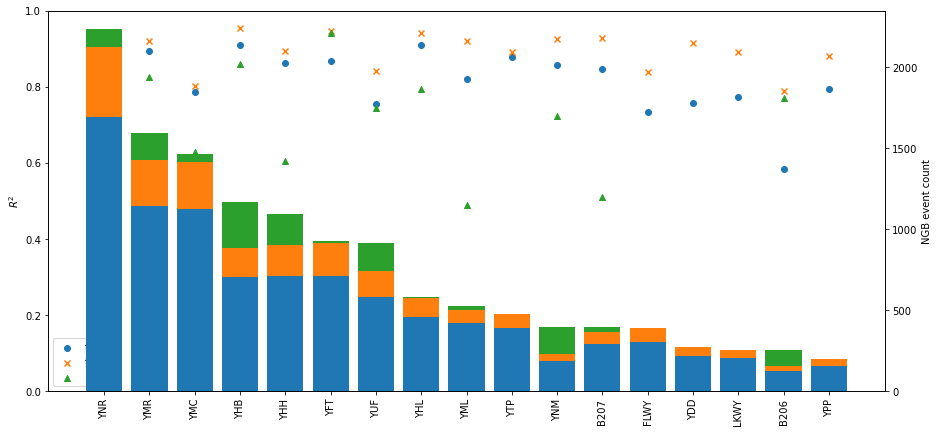

In [13]:
from collections import OrderedDict
fig = plt.figure(1, figsize=(15, 7))

x_range = range(first_stat, n_stats)
for ind in x_range:
    stat = stat_counts.iloc[ind].Station
    plt.scatter(ind, stat_results[stat]["test_r2"], label="test", marker="o", color="C0")
    plt.scatter(ind, stat_results[stat]["train_r2"], label="train", marker="x", color="C1")
    
    ngb_r2 = stat_results[stat]["ngb_r2"]
    if ngb_r2 is not None and ngb_r2 < 0:
        ngb_r2 = 0
    plt.scatter(ind, ngb_r2, label="ngb", marker="^", color="C2")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left")

ax1 = plt.gca()
ax1.set_xticks(x_range, labels=stat_counts.iloc[first_stat:n_stats].Station.values, rotation="vertical");
ax2 = ax1.twinx()

ax2.bar(x_range, results_df.train_count, label="train")
ax2.bar(x_range, results_df.test_count, bottom=results_df.train_count)
ax2.bar(x_range, results_df.ngb_count, bottom=results_df.train_count+results_df.test_count)

ax2.set_ylabel("NGB event count")
ax1.set_ylabel(r"$R^2$")
ax1.set_ylim([0, 1.0])

In [14]:
n_stats

17

(0.0, 1.0)

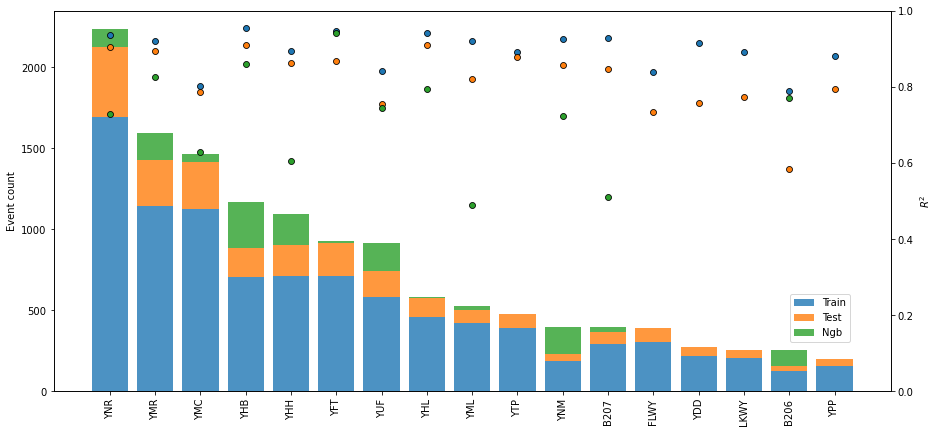

In [15]:
from collections import OrderedDict
fig = plt.figure(1, figsize=(15, 7))

x_range = range(first_stat, n_stats)

plt.bar(x_range, results_df.train_count, label="Train", alpha=0.8)
plt.bar(x_range, results_df.test_count, bottom=results_df.train_count, label="Test", alpha=0.8)
plt.bar(x_range, results_df.ngb_count, bottom=results_df.train_count+results_df.test_count, label="Ngb", alpha=0.8)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(0.88, 0.13))

ax1 = plt.gca()
ax1.set_xticks(x_range, labels=results_df["index"], rotation="vertical");
ax2 = ax1.twinx()

plt.scatter(x_range, results_df.train_r2, label="train", marker="o", color="C0", edgecolor="k", linewidth=0.8)
plt.scatter(x_range, results_df.test_r2, label="test", marker="o", color="C1", edgecolor="k", linewidth=0.8)

ngb_r2 = results_df["ngb_r2"].copy()
ngb_r2[ngb_r2 < 0] = 0.01

plt.scatter(x_range, ngb_r2, label="ngb", marker="o", color="C2", edgecolor="k", linewidth=0.8)

ax1.set_ylabel("Event count")
ax2.set_ylabel(r"$R^2$")
ax2.set_ylim([0, 1.0])

(0.0, 1.0)

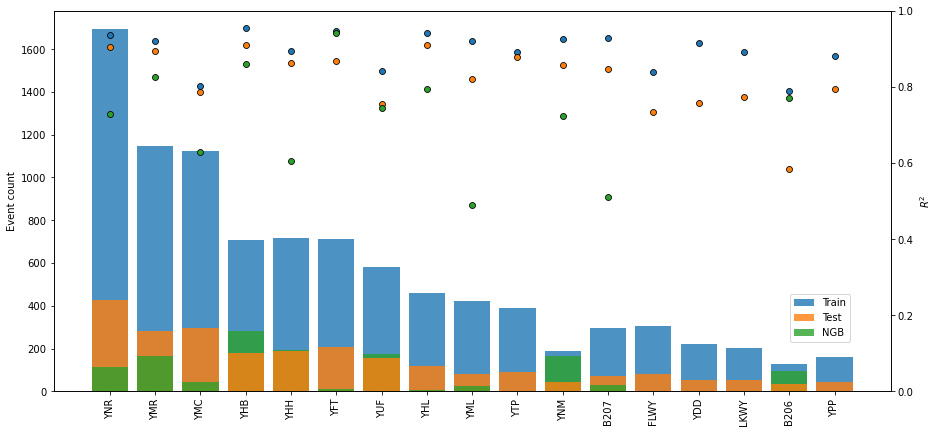

In [16]:
from collections import OrderedDict
fig = plt.figure(1, figsize=(15, 7))

x_range = range(first_stat, n_stats)

color_dict = {"train_count":"C0", "test_count":"C1", "ngb_count":"C2"}
label_dict = {"train_count":"Train", "test_count":"Test", "ngb_count":"NGB"}

for ind in range(len(results_df["index"])):
    stat = results_df.index[ind]
    counts = results_df.loc[stat][["test_count", "train_count", "ngb_count"]].sort_values(ascending=False)
    plt.bar(ind, counts.iloc[0], label=label_dict[counts.index[0]], alpha=0.8, color=color_dict[counts.index[0]])
    plt.bar(ind, counts.iloc[1], label=label_dict[counts.index[1]], alpha=0.8, color=color_dict[counts.index[1]])
    plt.bar(ind, counts.iloc[2], label=label_dict[counts.index[2]], alpha=0.8, color=color_dict[counts.index[2]])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(0.88, 0.13))

ax1 = plt.gca()
ax1.set_xticks(x_range, labels=results_df["index"], rotation="vertical");
ax2 = ax1.twinx()

plt.scatter(x_range, results_df.train_r2, label="train", marker="o", color="C0", edgecolor="k", linewidth=0.8)
plt.scatter(x_range, results_df.test_r2, label="test", marker="o", color="C1", edgecolor="k", linewidth=0.8)

ngb_r2 = results_df["ngb_r2"].copy()
ngb_r2[ngb_r2 < 0] = 0.01

plt.scatter(x_range, ngb_r2, label="ngb", marker="o", color="C2", edgecolor="k", linewidth=0.8)

ax1.set_ylabel("Event count")
ax2.set_ylabel(r"$R^2$")
ax2.set_ylim([0, 1.0])